In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from warnings import simplefilter
import numpy as np
import pandas as pd
plt.style.use('Solarize_Light2')
simplefilter('ignore')
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [2]:
dta=sm.datasets.sunspots.load_pandas().data
dta.index=pd.Index(sm.tsa.datetools.dates_from_range("1700","2008"))
dta.index.freq=dta.index.inferred_freq
del dta["YEAR"]

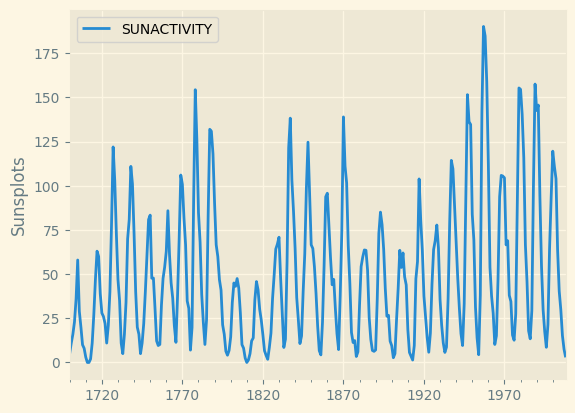

In [3]:
ax=dta.plot()
ax.set_ylabel("Sunsplots")
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(dta["SUNACTIVITY"])
print(result)

(np.float64(-2.8377807249381966), np.float64(0.05307642172812041), 8, 300, {'1%': np.float64(-3.4523371197407404), '5%': np.float64(-2.871222860740741), '10%': np.float64(-2.571929211111111)}, np.float64(2430.50034229055))


In [5]:
pvalue=result[1]
if pvalue <0.05:
    print("Stationary")
else:
    print("not stationary")

not stationary


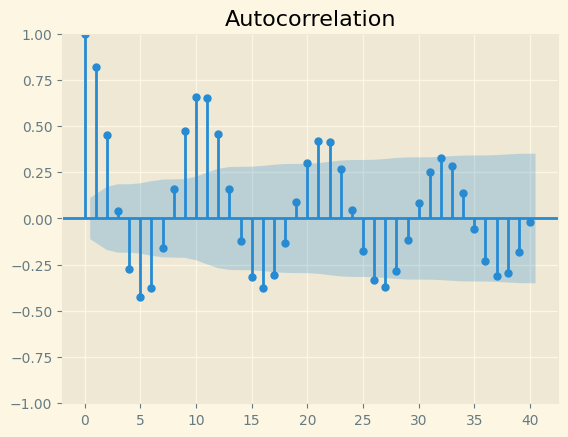

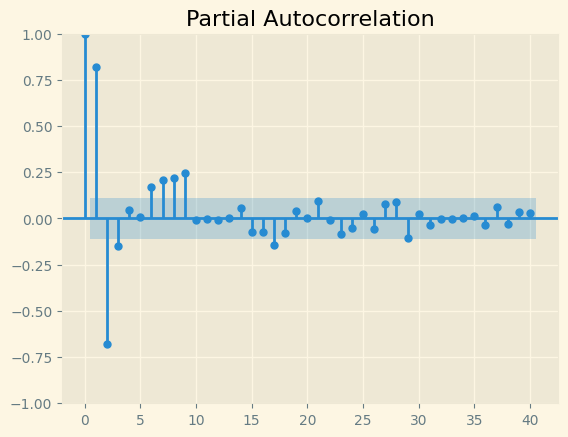

In [6]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(dta["SUNACTIVITY"],lags=40)
plot_pacf(dta["SUNACTIVITY"],lags=40)
plt.show()

0.7707182068126296


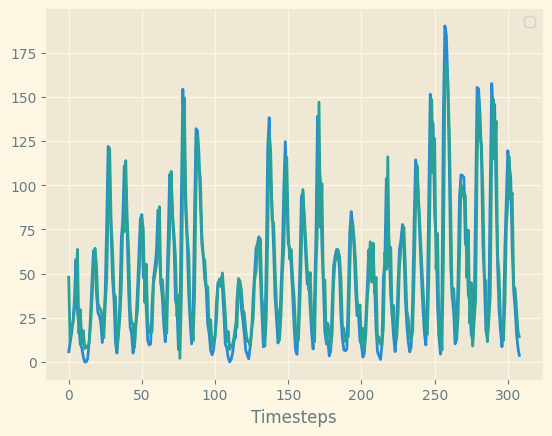

In [7]:
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
mod=ARIMA(list(dta["SUNACTIVITY"]),order=(1,0,1))
res=mod.fit()
pred=res.predict()
print(r2_score(dta,pred))
plt.plot(list(dta["SUNACTIVITY"]))
plt.plot(pred)
plt.legend(["Actual Sunspots"],["Predicted Sunspots"])
plt.xlabel("Timesteps")
plt.show()

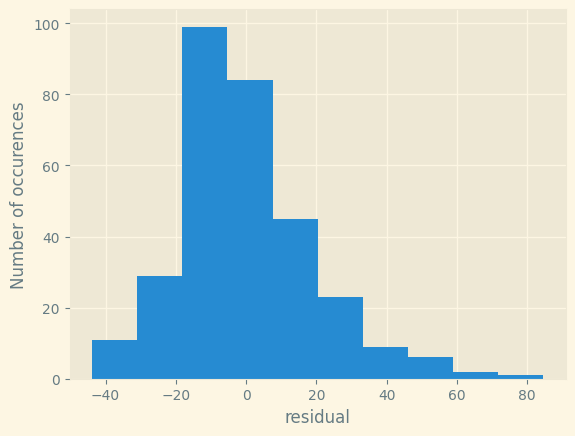

In [8]:
ax=pd.Series(res.resid).hist()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('residual')
plt.show()

In [9]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  309
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1352.613
Date:                Mon, 02 Jun 2025   AIC                           2713.226
Time:                        01:16:21   BIC                           2728.160
Sample:                             0   HQIC                          2719.197
                                - 309                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.7921      8.077      6.041      0.000      32.962      64.623
ar.L1          0.7355      0.046     15.921      0.000       0.645       0.826
ma.L1          0.5194      0.048     10.798      0.000       0.425       0.614
sigma2       369.1788     25.783     14.319      0.000     318.646     419.712
===================================================================================
Ljung-Box (L1) (Q):                   9.89   Jarque-Bera (JB):                73.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
from sklearn.model_selection import TimeSeriesSplit
data_array=dta.values
avg_errors=[]
for p in range(2):
    for q in range(5):
        errors=[]
        tscv=TimeSeriesSplit(test_size=10)
        for train_index,test_index in tscv.split(data_array):
            x_train,x_test=data_array[train_index],data_array[test_index]
            x_test_orig=x_test
            fcst=[]
            for stop in range(10):
                try:
                    mod=ARIMA(x_train,order=(p,0,q))
                    res=mod.fit()
                    fcst.append(res.forecast(steps=1))
                except:
                    print("errored")        
                    fcst.append(-9999999.)
                x_train=np.concatenate((x_train,x_test[0:1,:]))
                x_test=x_test[1:]
            errors.append(r2_score(x_test_orig,fcst))
        pq_result=[p,q,np.mean(errors)]
        print(pq_result)
        avg_errors.append(pq_result)
avg_errors=pd.DataFrame(avg_errors)
avg_errors.columns=['p','q','error']
result=avg_errors.pivot(index='p',columns='q')

[0, 0, np.float64(-0.19537571789500857)]
[0, 1, np.float64(0.5148074126202729)]
[0, 2, np.float64(0.6923588391828583)]
[0, 3, np.float64(0.731481026562277)]
[0, 4, np.float64(0.7709250086648808)]
[1, 0, np.float64(0.6258570123912045)]
[1, 1, np.float64(0.7165957003944337)]
[1, 2, np.float64(0.758649599276173)]
[1, 3, np.float64(0.7635345566999157)]
[1, 4, np.float64(0.757894457194436)]


In [11]:
avg_errors=pd.DataFrame(avg_errors)
avg_errors.columns=['p','q','error']
result=avg_errors.pivot(index='p',columns='q')

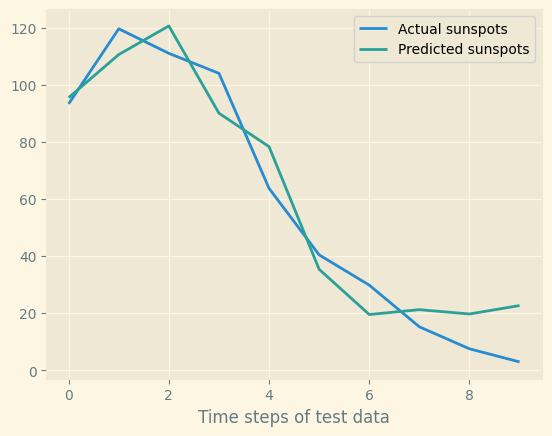

In [12]:
dta_array=dta.values
X_train,X_test=dta_array[:-10],dta_array[-10:]
X_test_orig=X_test
fcst=[]
for step in range(10):
    mod=ARIMA(X_train,order=(10,0,9))
    res=mod.fit()
    fcst.append(res.forecast(steps=1))
    X_train=np.concatenate((X_train,X_test[0:1,:]))
    X_test=X_test[1:]
plt.plot(X_test_orig)
plt.plot(fcst)
plt.legend(["Actual sunspots","Predicted sunspots"])
plt.xlabel('Time steps of test data')
plt.show()